# Feature Analysis for Majestic Million [:1000]

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from pathlib import Path
from tld import get_fld
from urllib.parse import urlparse

PREPROCESSED = Path('../data/preprocessed')
CATEGORIZAION = Path('../data/categorization')
ASSETS = Path(f'../assets/majestic-1000')
CHART_FILE_EXTENSION = ".svg"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = sns.color_palette("Set2")
bar_width = .75
sns.set(rc = {'figure.figsize':(12,6)})
sns.set_theme(style='white')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Dataset description

In [3]:
resources = pd.read_csv(PREPROCESSED / 'resources.csv')

cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time', 'outgoing', 'outgoing_sizes']
for col in cols:
    resources[col] = resources[col].apply(eval)

resources.head()

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,before accept,False,NaN,"[347, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.404504, 0.595066]",[20],[347]
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[51, 59, 61]",mozilla.org,False,before accept,False,NaN,"[351, 1460, 305]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.6612, 0.6762, 0.676207]",[51],[351]
2,815a3078fff2a4cd95623602374ca6ff1b6cf1628e368dd60e1dc44b,https://www.mozilla.org/en-US/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,65,81.0,84.0,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]",mozilla.org,False,before accept,False,NaN,"[56, 1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.677486, 0.693474, 0.693644, 0.693651, 0.693653, 0.693655, 0.693963, 0.693986, 0.693987, 0.693988, 0.693989, 0.694866, 0.694871, 0.694873, 0.694874, 0.694875]",[65],[56]
3,5d10a4d49a66e53dc9ab3aa886139668faa92c3ee3bbcba0c059a982,https://www.mozilla.org/media/js/site.7afc1ba3aa92.js,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,86,108.0,108.0,application/javascript,www.mozilla.org,mozilla.org,13.32.119.185,"[86, 107, 108]",mozilla.org,False,before accept,False,NaN,"[163, 1460, 1240]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.707143, 0.722181, 0.72219]",[86],[163]
4,1a3a38bda292310aeefc8acaed61808455b194791404e39153ad6daf,https://www.mozilla.org/media/css/protocol-mozilla.120b0a0d8b56.css,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,88,117.0,117.0,text/css,www.mozilla.org,mozilla.org,13.32.119.185,"[88, 110, 111, 112, 113, 114, 115, 116, 117]",mozilla.org,False,before accept,False,NaN,"[104, 1460, 1460, 1460, 1460, 1300, 1460, 1396, 250]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.708264, 0.72345, 0.723454, 0.723456, 0.723457, 0.723458, 0.723866, 0.723887, 0.723898]",[88],[104]


In [119]:
communication = resources.groupby(['study_name', 'website_call', 'ip']).agg({'packets': lambda x: x.tolist(),
                                                                     'sizes': lambda x: x.tolist(),
                                                                     'outgoing': lambda x: x.tolist(),
                                                                     'outgoing_sizes': lambda x: x.tolist(),
                                                                     'hostname': lambda x: set(x.tolist()),
                                                                     'is_tp': lambda x: x.all(),
                                                                     'is_tracker': lambda x: x.tolist()})
communication['is_tracker_all'] = communication['is_tracker'].apply(all)
communication.head(2)

packets  \
study_name       website_call      ip                                                  
accepting policy 1.bp.blogspot.com 172.217.23.100  [[69, 81, 89, 91], [70, 97, 101]]   
                                   216.58.212.161                [[21, 29, 31, 105]]   

                                                                                       sizes  \
study_name       website_call      ip                                                          
accepting policy 1.bp.blogspot.com 172.217.23.100  [[343, 1460, 1460, 786], [95, 1460, 515]]   
                                   216.58.212.161                     [[351, 1460, 632, 70]]   

                                                       outgoing  \
study_name       website_call      ip                             
accepting policy 1.bp.blogspot.com 172.217.23.100  [[69], [70]]   
                                   216.58.212.161        [[21]]   

                                                  outgoing_sizes  \
study_name       website_call      ip                              
accepting policy 1.bp.blogspot.com 172.217.23.100  [[343], [95]]   
                                   216.58.212.161        [[351]]   

                                                            hostname  is_tp  \
study_name       website_call      ip                                         
accepting policy 1.bp.blogspot.com 172.217.23.100       {google.com}   True   
                                   216.58.212.161  {bp.blogspot.com}  False   

                                                       is_tracker  \
study_name       website_call      ip                               
accepting policy 1.bp.blogspot.com 172.217.23.100  [False, False]   
                                   216.58.212.161         [False]   

                                                   is_tracker_all  
study_name       website_call      ip                              
accepting policy 1.bp.blogspot.com 172.217.23.100           False  
                                   216.58.212.161           False

In [5]:
packets = resources.explode(['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time'], ignore_index=True)
packets = packets.drop(columns=['outgoing', 'outgoing_sizes'])
packets.rename(columns={'packets':'packet', 'sizes': 'size'}, inplace=True)
packets['out'] = packets['ip_src'].apply(lambda x: x.startswith('172.17'))
packets.head()

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packet,hostname,is_tp,study_name,is_tracker,filter,size,ip_src,ip_dst,rel_time,out
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,20,mozilla.org,False,before accept,False,NaN,347,172.17.0.4,44.236.72.93,0.404504,True
1,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,26,mozilla.org,False,before accept,False,NaN,435,44.236.72.93,172.17.0.4,0.595066,False
2,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,51,mozilla.org,False,before accept,False,NaN,351,172.17.0.4,13.32.119.185,0.6612,True
3,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,59,mozilla.org,False,before accept,False,NaN,1460,13.32.119.185,172.17.0.4,0.6762,False
4,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,61,mozilla.org,False,before accept,False,NaN,305,13.32.119.185,172.17.0.4,0.676207,False


In [6]:
print("nytimes.com FP Trackers")
display(resources[(resources['website_call'] == 'nytimes.com') & (resources['study_name'] == 'after accept') & (~resources['is_tp']) & (resources['is_tracker'])].head())
print("nytimes.com TP Trackers")
display(resources[(resources['website_call'] == 'nytimes.com') & (resources['study_name'] == 'after accept') & (resources['is_tp']) & (resources['is_tracker'])].head())

nytimes.com FP Trackers


,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes
171640,8a87d85884d8620589116a99d30471251b115d2e893a1ef8c8d8531b,https://a.et.nytimes.com/track,50c1215ad18009b13d2a403d058769f4650a3bea113736cdf743f43b,52.54.49.121,http2,POST,nytimes.com,2808,2899.0,2901.0,application/json; charset=utf-8,www.nytimes.com,nytimes.com,151.101.113.164,"[2807, 2808, 2809, 2899, 2901]",nytimes.com,False,after accept,True,NetworkFilter,"[1460, 248, 625, 829, 31]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 52.54.49.121, 52.54.49.121]","[52.54.49.121, 52.54.49.121, 52.54.49.121, 172.17.0.2, 172.17.0.2]","[0.868187, 0.868188, 0.86825, 1.019683, 1.020114]","[2807, 2808, 2809]","[1460, 248, 625]"
171644,2e66aa1c11c31fdd67a34b6c9c70b941fc818a44311ef59e3541c8be,https://als-svc.nytimes.com/als?uri=https%3A%2F%2Fwww.nytimes.com%2Fpages%2Findex.html&typ=&prop=nyt&plat=web,5cd4b1caeb3003c307dd31ddd17f6a182c5ecaffde0a2f7e0aa07fc6,52.54.49.121,http2,GET,nytimes.com,2892,2915.0,2915.0,application/json; charset=utf-8,www.nytimes.com,nytimes.com,151.101.113.164,"[2891, 2892, 2915]",nytimes.com,False,after accept,True,NetworkFilter,"[1460, 165, 1112]","[172.17.0.2, 172.17.0.2, 52.54.49.121]","[52.54.49.121, 52.54.49.121, 172.17.0.2]","[0.90802, 0.908022, 1.05038]","[2891, 2892]","[1460, 165]"
171833,f12bfd1097e2e743aebc0655c131a02616c47ae24d92420776944d9b,https://a.et.nytimes.com/track,50c1215ad18009b13d2a403d058769f4650a3bea113736cdf743f43b,52.54.49.121,http2,POST,nytimes.com,6213,6376.0,6376.0,application/json; charset=utf-8,www.nytimes.com,nytimes.com,151.101.113.164,"[6213, 6215, 6216, 6217, 6218, 6219, 6376]",nytimes.com,False,after accept,True,NetworkFilter,"[134, 1460, 1460, 1460, 1460, 533, 506]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 52.54.49.121]","[52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 172.17.0.2]","[4.124746, 4.125009, 4.12501, 4.125051, 4.125053, 4.125163, 4.280553]","[6213, 6215, 6216, 6217, 6218, 6219]","[134, 1460, 1460, 1460, 1460, 533]"
171867,fe578ceb4f50b395ef31b3a61c93b138a4d36f26cab66397727bafaf,https://a.et.nytimes.com/track,50c1215ad18009b13d2a403d058769f4650a3bea113736cdf743f43b,52.54.49.121,http2,POST,nytimes.com,6914,7111.0,7111.0,application/json; charset=utf-8,www.nytimes.com,nytimes.com,151.101.113.164,"[6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6924, 7111]",nytimes.com,False,after accept,True,NetworkFilter,"[529, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1019, 506]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 52.54.49.121]","[52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 172.17.0.2]","[5.428715, 5.428812, 5.428812, 5.428846, 5.428847, 5.428908, 5.428909, 5.428948, 5.428949, 5.428996, 5.590507]","[6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6924]","[529, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1019]"
171883,c940bb5aa3fc98bae4c240c19d1eb1d7521fab9cdba2e9a9171d2a42,https://a.et.nytimes.com/track,50c1215ad18009b13d2a403d058769f4650a3bea113736cdf743f43b,52.54.49.121,http2,POST,nytimes.com,7291,7367.0,7368.0,application/json; charset=utf-8,www.nytimes.com,nytimes.com,151.101.113.164,"[7291, 7292, 7293, 7294, 7367, 7368]",nytimes.com,False,after accept,True,NetworkFilter,"[1095, 1460, 1460, 557, 497, 31]","[172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 52.54.49.121, 52.54.49.121]","[52.54.49.121, 52.54.49.121, 52.54.49.121, 52.54.49.121, 172.17.0.2, 172.17.0.2]","[5.976475, 5.97658, 5.976581, 5.976582, 6.130224, 6.130961]","[7291, 7292, 7293, 7294]","[1095, 1460, 1460, 557]"


nytimes.com TP Trackers


,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes
171611,ae480580640de2a74fe3d068a11eecbb6342673fea8d9d5b80066c27,https://js.sentry-cdn.com/7bc8bccf5c254286a99b11c68f6bf4ce.min.js,6b1656a4e9447e2dcdf319398922487c71f8aa89cd8fc35f5becad69,151.101.66.217,http2,GET,nytimes.com,866,890.0,892.0,text/javascript,www.nytimes.com,nytimes.com,151.101.113.164,"[866, 890, 892]",sentry-cdn.com,True,after accept,True,NetworkFilter,"[407, 1460, 14]","[172.17.0.2, 151.101.66.217, 151.101.66.217]","[151.101.66.217, 172.17.0.2, 172.17.0.2]","[0.429731, 0.439805, 0.439815]",[866],[407]
171649,0f88a89b907fdd31f44269b311e043feb20c451dc94459d3ff7f0386,https://securepubads.g.doubleclick.net/tag/js/gpt.js,8f603269484e4de652e53d6c56741c5302147a4623e11cd788457538,142.250.184.226,http2,GET,nytimes.com,3058,3066.0,3095.0,text/javascript,www.nytimes.com,nytimes.com,151.101.113.164,"[3058, 3066, 3083, 3084, 3092, 3093, 3095]",doubleclick.net,True,after accept,True,NetworkFilter,"[360, 1460, 1460, 1210, 1460, 1449, 150]","[172.17.0.2, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226]","[142.250.184.226, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2]","[1.269394, 1.286915, 1.287716, 1.287718, 1.289094, 1.289096, 1.293245]",[3058],[360]
171650,4a140f391459821c4ff9a4ee7ba05d1ad30af721bd9bdb5ed4088606,https://securepubads.g.doubleclick.net/gpt/pubads_impl_2022110701.js?cb=31070811,8f603269484e4de652e53d6c56741c5302147a4623e11cd788457538,142.250.184.226,http2,GET,nytimes.com,3099,3102.0,3234.0,text/javascript,www.nytimes.com,nytimes.com,151.101.113.164,"[3099, 3102, 3113, 3114, 3126, 3127, 3140, 3142, 3160, 3162, 3177, 3178, 3196, 3198, 3214, 3216, 3231, 3232, 3234]",doubleclick.net,True,after accept,True,NetworkFilter,"[83, 1460, 1460, 1460, 1460, 1341, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 1460, 569]","[172.17.0.2, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226]","[142.250.184.226, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2, 172.17.0.2]","[1.47496, 1.482787, 1.483606, 1.483607, 1.48468, 1.484792, 1.49051, 1.490589, 1.491291, 1.491299, 1.491484, 1.491727, 1.493029, 1.493037, 1.493413, 1.493416, 1.49399, 1.493992, 1.493997]",[3099],[83]
171668,c073698da4f5fcb08c9c44325093bfb0484b9a5fa14baaca4fc21db6,https://adservice.google.com/adsid/integrator.js?domain=www.nytimes.com,98c3f48c195c5b5737b559cffac49a563cbe60266f7c1ba9968d78eb,172.217.16.194,http2,GET,nytimes.com,4383,4399.0,4399.0,application/javascript; charset=UTF-8,www.nytimes.com,nytimes.com,151.101.113.164,"[4383, 4399]",google.com,True,after accept,True,NetworkFilter,"[313, 1261]","[172.17.0.2, 172.217.16.194]","[172.217.16.194, 172.17.0.2]","[2.12422, 2.140474]",[4383],[313]
171669,52ff7295a184bddef22a402afa060b7e05e77c7085744beb11e8c83b,https://adservice.google.de/adsid/integrator.js?domain=www.nytimes.com,9d856eea5511fb1da12621a10980075055c4fa9d547358925c2c961d,142.250.186.66,http2,GET,nytimes.com,4387,4405.0,4405.0,application/javascript; charset=UTF-8,www.nytimes.com,nytimes.com,151.101.113.164,"[4387, 4405]",google.de,True,after accept,True,NetworkFilter,"[313, 1274]","[172.17.0.2, 142.250.186.66]","[142.250.186.66, 172.17.0.2]","[2.125143, 2.145085]",[4387],[313]


In [7]:
accept_cookie = pd.read_csv(PREPROCESSED / 'Cookie-Accept-2022-11-09.csv')
accept_cookie['website_call'] = accept_cookie[accept_cookie['is_accept']]['url'].apply(get_fld)


# Top 5 banner_text
accept_cookie["banner_text"].value_counts().head()

accept all cookies    61
accept all            61
accept                51
i accept              43
alle akzeptieren      25
Name: banner_text, dtype: int64

In [8]:
print(f"Studies: {resources['study_name'].unique()}")
print(f"Called websites: {len(resources['website_call'].unique())}")
print(f"Count unique domains: first-party={len(resources['context'].unique())} / third-party={len(resources[resources['is_tp']]['hostname'].unique())}")
print(f"Average parties per domain: parties={resources.groupby('website_call')['hostname'].unique().apply(len).mean():.2f} / tracking-parties={resources[resources['is_tracker']].groupby('website_call')['hostname'].unique().apply(len).mean():.2f}")
print(f"Count cookie-accept: accepted={len(accept_cookie[accept_cookie['is_accept']])} ({len(accept_cookie[accept_cookie['is_accept']]) / len(resources['website_call'].unique()):.4f})")
print(f"Count resources: total={len(resources)} first-party={len(resources[~resources['is_tp']])} / third-party={len(resources[resources['is_tp']])}")
print(f"Count packets: total={len(packets)} in={len(packets[~packets['out']])} / out={len(packets[packets['out']])}")
print(f"Count tracking resources: is_tracker={len(resources[resources['is_tracker']])} / not is_tracker={len(resources[~resources['is_tracker']])}")
print(f"Count protocol http={len(resources[resources['protocol'] == 'http'])} / http2={len(resources[resources['protocol'] == 'http2'])}")

Studies: ['before accept' 'accepting policy' 'after accept']
Called websites: 933
Count unique domains: first-party=827 / third-party=2161
Average parties per domain: parties=25.52 / tracking-parties=22.33
Count cookie-accept: accepted=429 (0.4598)
Count resources: total=265994 first-party=83993 / third-party=182001
Count packets: total=3578911 in=3258443 / out=320468
Count tracking resources: is_tracker=105586 / not is_tracker=160408
Count protocol http=40878 / http2=225116


In [9]:
resources['size'] = resources['sizes'].apply(sum)
resources['out_size'] = resources['outgoing_sizes'].apply(sum)
resources['in_size'] = resources['size'] - resources['out_size']
resources[resources['method'] == 'GET'].groupby('is_tracker')[['size', 'out_size', 'in_size']].count()

,size,out_size,in_size
is_tracker,,,
False,154932,154932,154932
True,91139,91139,91139


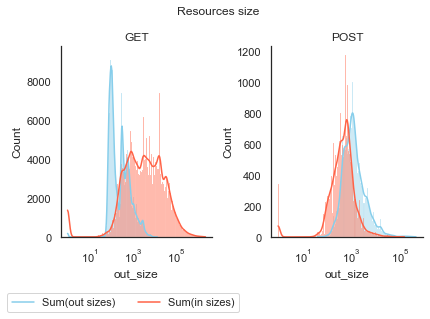

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

for ax, method in zip(axs, ['GET', 'POST']):
    sns.histplot(x='out_size', data=resources[resources['method'] == method].replace(to_replace=0, value=1), label="Sum(out sizes)", log_scale=True, color='skyblue', kde=True, ax=ax)
    sns.histplot(x='in_size', data=resources[resources['method'] == method].replace(to_replace=0, value=1), label="Sum(in sizes)", log_scale=True, color='tomato', kde=True, ax=ax)
    ax.set_title(f'{method}')

fig.legend(['Sum(out sizes)', 'Sum(in sizes)'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Resources size")
fig.tight_layout()
plt.show()

In [11]:
def calc_entropy(data):
    p_data = np.bincount(data) / len(data)
    return stats.entropy(p_data, base=2)

communication['service_entropy'] = communication['is_tracker'].apply(calc_entropy)
print("Max entropy is 1, which means web services are maximal impure delivering the same number of tracking and non tracking resources")
print(f"Mean service entropy overall={communication['service_entropy'].mean():.3f} first-party={communication[~communication['is_tp']]['service_entropy'].mean():.3f} third-party={communication[communication['is_tp']]['service_entropy'].mean():.3f}")

Max entropy is 1, which means web services are maximal impure delivering the same number of tracking and non tracking resources
Mean service entropy overall=0.028 first-party=0.072 third-party=0.023


In [12]:
websites_entropy = communication.groupby('website_call')['service_entropy'].mean()
websites_entropy.loc['nytimes.com']

0.024093721519077932

<AxesSubplot:xlabel='tracking_ratio', ylabel='Count'>

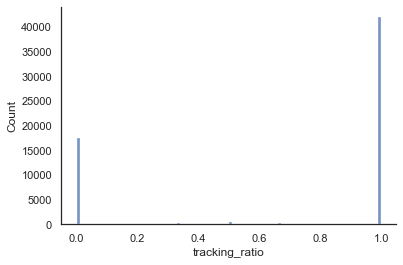

In [99]:
communication['tracking_ratio'] = communication['is_tracker'].apply(lambda x: sum(x) / len(x))
sns.histplot(x='tracking_ratio', data=communication, bins=100)

In [14]:
with open(CATEGORIZAION / f'categorization Majestic-1000.json') as f:
    categorization = pd.DataFrame([url for batch in json.load(f) for url in batch['urls']])

categorization = categorization.set_index('url')
categorization.head()

,categoryNames
url,
google.com,[Search Engines & Portals]
facebook.com,[Social Networking]
youtube.com,"[Entertainment, Streaming Media & Downloads]"
twitter.com,[Social Networking]
instagram.com,"[Social Networking, Image Sharing]"


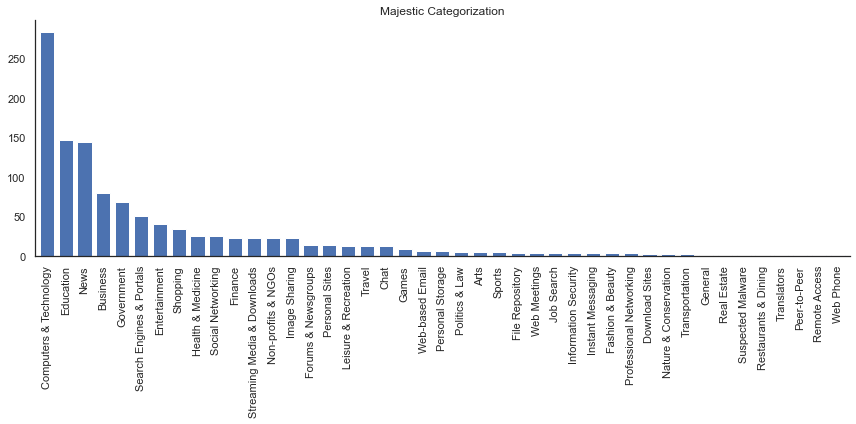

In [15]:
websites_called = resources['website_call'].unique()
num_categorization = categorization.loc[websites_called]['categoryNames'].explode().value_counts()
num_categorization.plot.bar(figsize=(12,6), width=bar_width)
plt.title("Majestic Categorization")
#plt.ylabel('Percentage [%]')
plt.tight_layout()
plt.savefig(ASSETS / f'majestic-categroization{CHART_FILE_EXTENSION}')
plt.show()

In [16]:
resources[(resources['website_call'] == 'vanityfair.com') & (resources['is_tracker']) & (resources['study_name'] == 'after accept')].head(30)

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,outgoing,outgoing_sizes,size,out_size,in_size
53333,f09a8d97f24f7e4c944ce3267efb0503c311246fac54dd08ef8bf954,https://www.vanityfair.com/hotzones/esi/vanity-fair/prebid.min.js,6eb50e7e5f29431c6ee35351eb23ab6b6028e35de7a73f9b42ecd84c,151.101.112.239,http,GET,vanityfair.com,402,562.0,NaN,application/javascript; charset=utf-8,www.vanityfair.com,vanityfair.com,151.101.112.239,"[398, 399, 400, 401, 402, 546, 548, 550, 552, 554, 556, 558, 560, 562]",vanityfair.com,False,after accept,True,NetworkFilter,"[1460, 1460, 1460, 1460, 367, 1460, 1460, 1460, 1358, 1460, 1460, 1460, 1460, 1068]","[172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239]","[151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 151.101.112.239, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.349876, 0.34988, 0.349881, 0.350055, 0.350058, 0.364665, 0.364688, 0.364694, 0.364698, 0.364702, 0.364706, 0.36471, 0.364714, 0.364718]","[398, 399, 400, 401, 402]","[1460, 1460, 1460, 1460, 367]",18853,6207,12646
53336,2f2e1fe3f57aaa6eddde8dadb216c9f988d20d1d2217ccd0a24055e6,https://securepubads.g.doubleclick.net/tag/js/gpt.js,e014c947a4b4da8a26073cc9cf3cec9a62eb06fbb87774903d5b5fce,142.250.184.226,http2,GET,vanityfair.com,668,985.0,1017.0,text/javascript,www.vanityfair.com,vanityfair.com,151.101.112.239,"[668, 985, 1003, 1016, 1017]",doubleclick.net,True,after accept,True,NetworkFilter,"[358, 1460, 36, 1460, 1262]","[172.17.0.4, 142.250.184.226, 142.250.184.226, 142.250.184.226, 142.250.184.226]","[142.250.184.226, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.435776, 0.473046, 0.473926, 0.481376, 0.481381]",[668],[358],4576,358,4218
53337,17b06e3acb0b1c3d7bd3fdf8d05fce94492c71939586214fc3aa2a0a,https://c.amazon-adsystem.com/aax2/apstag.js,6a6a6d78a830e8f5cc568a95cfb38d86b2475a0035224f3dbebf47db,52.222.209.55,http2,GET,vanityfair.com,690,776.0,868.0,application/javascript,www.vanityfair.com,vanityfair.com,151.101.112.239,"[690, 758, 760, 762, 764, 766, 768, 769, 772, 773, 774, 775, 776, 795, 796, 797, 798, 799, 800, 801, 804, 805, 806, 807, 808, 817, 818, 819, 820, 821, 822, 823, 867, 868]",amazon-adsystem.com,True,after accept,True,NetworkFilter,"[296, 1460, 1460, 1364, 1460, 1460, 1460, 1332, 1460, 1460, 1460, 1460, 570, 1460, 1460, 1460, 1460, 1460, 1460, 1236, 1460, 1396, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1460, 1300, 1460, 349]","[172.17.0.4, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55, 52.222.209.55]","[52.222.209.55, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.438227, 0.448905, 0.448914, 0.449264, 0.449408, 0.449418, 0.449423, 0.449426, 0.449567, 0.4496, 0.449605, 0.449608, 0.449612, 0.450277, 0.450507, 0.450534, 0.450536, 0.450538, 0.450539, 0.45054, 0.451211, 0.451216, 0.451235, 0.451239, 0.451241, 0.451909, 0.451923, 0.452163, 0.452168, 0

In [17]:
num_tracker = pd.DataFrame(resources[resources['is_tracker']].groupby('website_call')['is_tracker'].count())
num_tracker = num_tracker.join(categorization).explode("categoryNames")
num_tracker[num_tracker['categoryNames'] == 'Download Sites'].sort_values('is_tracker', ascending=False).head(10)

,is_tracker,categoryNames


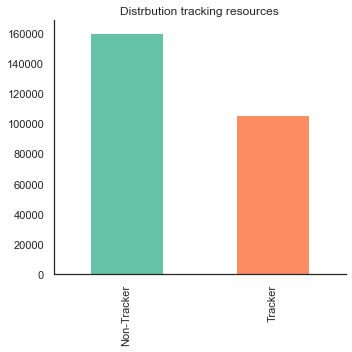

In [18]:
resources['is_tracker'].value_counts().rename(index={False: 'Non-Tracker', True: 'Tracker'}).plot(kind='bar', color=color_cycle, figsize=(5,5))
plt.title("Distrbution tracking resources")
plt.tight_layout()
plt.savefig(ASSETS / f'tracker-nontracker bar chart{CHART_FILE_EXTENSION}')
plt.show()

Number Tracker - First-Party: 5669
Number Tracker - Third-Party: 99917
Number Non-Tracker - First-Party: 78324
Number Non-Tracker - Third-Party: 82084


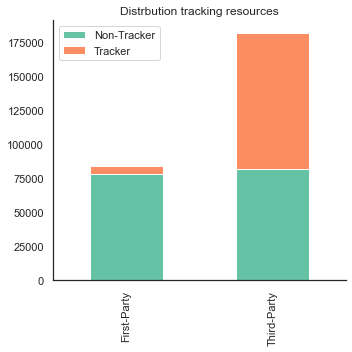

In [19]:
TF = len(resources[(resources['is_tracker']) & (~resources['is_tp'])])
TT = len(resources[(resources['is_tracker']) & (resources['is_tp'])])
NTF = len(resources[(~resources['is_tracker']) & (~resources['is_tp'])])
NTT = len(resources[(~resources['is_tracker']) & (resources['is_tp'])])
print(f"Number Tracker - First-Party: {TF}")
print(f"Number Tracker - Third-Party: {TT}")
print(f"Number Non-Tracker - First-Party: {NTF}")
print(f"Number Non-Tracker - Third-Party: {NTT}")


groups = [[NTF, NTT], [TF, TT]]
group_labels = ['Non-Tracker', 'Tracker']

pd.DataFrame(groups, columns=['First-Party', 'Third-Party'], index=group_labels).T.plot.bar(figsize=(5,5), stacked=True, color=color_cycle)
plt.title("Distrbution tracking resources")
plt.tight_layout()
plt.savefig(ASSETS / f'tracker-nontracker-by-party{CHART_FILE_EXTENSION}')
plt.show()

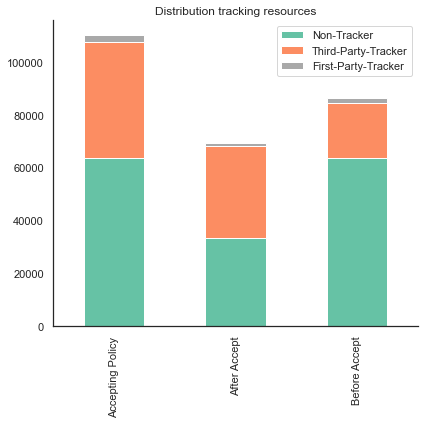

In [20]:
study_tracking = {}
for name, gp in resources.groupby('study_name'):
    study_tracking[name] = {'non_tracker': len(gp) - gp['is_tracker'].sum(),
                            'first_tracker': gp[~gp['is_tp']]['is_tracker'].sum(),
                            'third_tracker': gp[gp['is_tp']]['is_tracker'].sum()}

study_tracking = pd.DataFrame(study_tracking).T
study_tracking = study_tracking.rename(index={'accepting policy': 'Accepting Policy', 'after accept': 'After Accept', 'before accept': 'Before Accept'})

color = [color_cycle[0], color_cycle[1], 'darkgrey']
study_tracking.plot(y=['non_tracker', 'third_tracker', 'first_tracker'], kind='bar', stacked=True, color=color, figsize=(6,6))
    
plt.title("Distribution tracking resources")
plt.legend(['Non-Tracker', 'Third-Party-Tracker', 'First-Party-Tracker'])
plt.tight_layout()
plt.savefig(ASSETS / f'study-tacking-overview{CHART_FILE_EXTENSION}')
plt.show()

In [21]:
res_accept = resources.merge(accept_cookie, on='website_call')
res_accept_filtered = res_accept[(res_accept['study_name'] == 'before accept') & (res_accept['is_accept'])]
nontracker = len(res_accept_filtered[~res_accept_filtered['is_tracker']])
fptracker = len(res_accept_filtered[(res_accept_filtered['is_tracker']) & (~res_accept_filtered['is_tp'])])
tptracker = len(res_accept_filtered[(res_accept_filtered['is_tracker']) & (res_accept_filtered['is_tp'])])

study_trackingT = study_tracking.T
study_trackingT['Before Accept*'] = pd.Series({'non_tracker': nontracker, 'first_tracker': fptracker, 'third_tracker': tptracker})

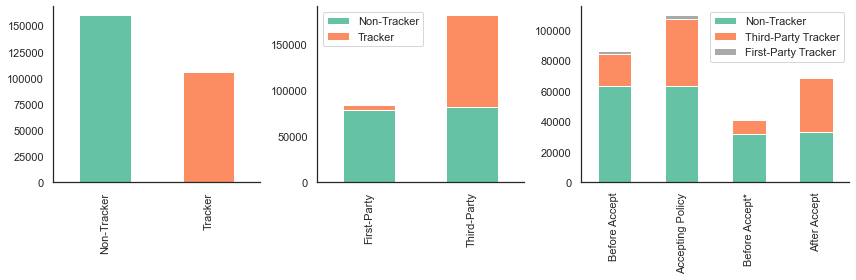

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1, 1.3]})
color = [color_cycle[0], color_cycle[1], 'darkgrey']

resources['is_tracker'].value_counts().rename(index={False: 'Non-Tracker', True: 'Tracker'}).plot(kind='bar', color=color_cycle, ax=axs[0])
pd.DataFrame(groups, columns=['First-Party', 'Third-Party'], index=group_labels).T.plot.bar(stacked=True, color=color_cycle, ax=axs[1])
#study_tracking.plot(y=['non_tracker', 'third_tracker', 'first_tracker'], kind='bar', stacked=True, color=color, ax=axs[2])
study_trackingT.T.reindex(["Before Accept", "Accepting Policy", "Before Accept*", "After Accept"]).plot(y=['non_tracker', 'third_tracker', 'first_tracker'], kind='bar', stacked=True, color=color, ax=axs[2])
axs[2].legend(['Non-Tracker', 'Third-Party Tracker', 'First-Party Tracker'])


fig.tight_layout()
fig.savefig(ASSETS / f'tracker-distribution{CHART_FILE_EXTENSION}')
plt.show()

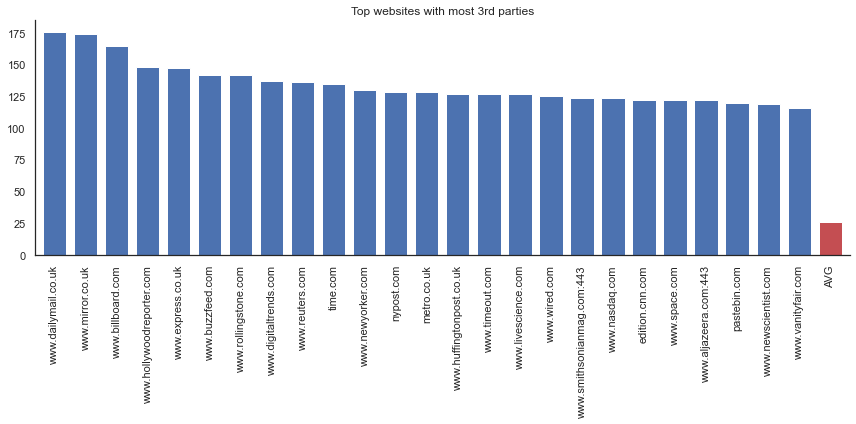

In [23]:
tp_on_websites = resources[resources['is_tp']].groupby('first_party')['hostname'].unique().apply(len) / resources.groupby('first_party')['website_call'].unique().apply(len)
top_tp_websites = tp_on_websites.sort_values(ascending=False)[:25]
top_tp_websites = pd.concat([top_tp_websites, pd.Series({'AVG': tp_on_websites.mean()})]).sort_values(ascending=False)

ax = top_tp_websites.plot(kind='bar', figsize=(12,6), width=bar_width)

highlight = 'AVG'
pos = top_tp_websites.index.get_loc(highlight)

ax.patches[pos].set_facecolor('r')

plt.title("Top websites with most 3rd parties")
plt.tight_layout()
plt.savefig(ASSETS / f'top-tp-by-first-party{CHART_FILE_EXTENSION}')
plt.show()

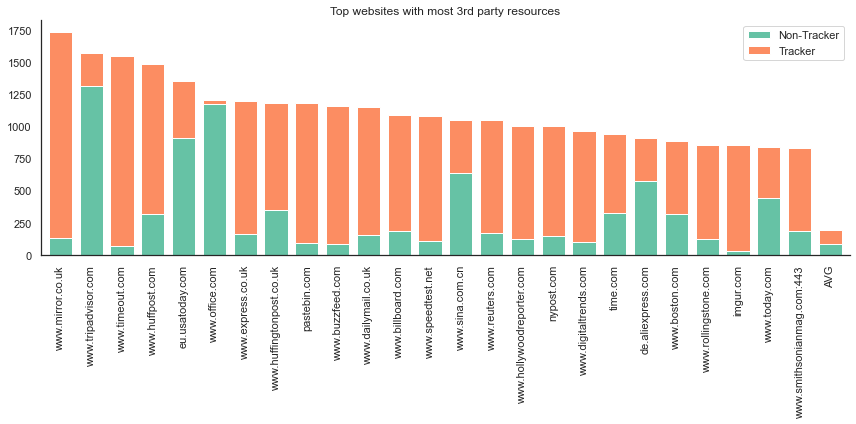

In [24]:
fps = resources.groupby('first_party')

df_fp = {}

for fp, gp in fps:
    n = len(gp['website_call'].unique())
    df_fp[fp] = {'third-party requests': len(gp[gp['is_tp']]) / n, 'tracker': len(gp[(gp['is_tp']) &(gp['is_tracker'])]) / n}

df_fp = pd.DataFrame(df_fp).T
df_fp['nontracker'] = df_fp['third-party requests'] - df_fp['tracker']
df_fp_top = df_fp.sort_values(by='third-party requests', ascending=False)[:25]

avg = df_fp.mean()
df_fp_top.loc['AVG'] = avg

df_fp_top.sort_values(by='third-party requests', ascending=False).plot(y=['nontracker', 'tracker'], width=bar_width, kind="bar", stacked=True, color=color_cycle, figsize=(12,6))

plt.title("Top websites with most 3rd party resources")
ax.set_xlabel("Domain")
plt.legend(["Non-Tracker", "Tracker"])
plt.tight_layout()
plt.savefig(ASSETS / f'top-tp-tracking-resources-by-first-party{CHART_FILE_EXTENSION}')
plt.show()

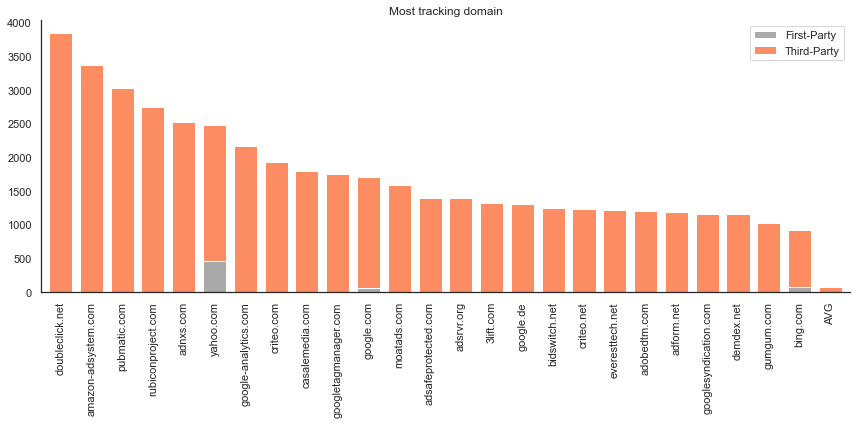

In [25]:
tracker_domain = pd.DataFrame()
tracker_domain['domain'] = resources[resources['is_tracker']]['hostname']
tracker_domain['is_tp'] = resources[resources['is_tracker']]['is_tp']
tracker_domain_count = {}
for party, gp in tracker_domain.groupby('domain'):
    tracker_domain_count[party] = {'tracker': len(gp), 'tp': gp['is_tp'].sum(), 'fp': len(gp) - gp['is_tp'].sum()}

tracker_domain_count = pd.DataFrame(tracker_domain_count).T

top_tracker_domain_count = tracker_domain_count.sort_values(by='tracker', ascending=False)[:25]
avg = tracker_domain_count.mean()
top_tracker_domain_count.loc['AVG'] = avg

color = ['darkgrey', color_cycle[1]]
top_tracker_domain_count.sort_values(by='tracker', ascending=False).plot(y=['fp', 'tp'], width=bar_width, kind='bar', stacked=True, color=color, figsize=(12,6))
    
plt.title("Most tracking domain")
plt.legend(['First-Party', 'Third-Party'])
plt.tight_layout()
plt.savefig(ASSETS / f'most-tracking-domain{CHART_FILE_EXTENSION}')
plt.show()

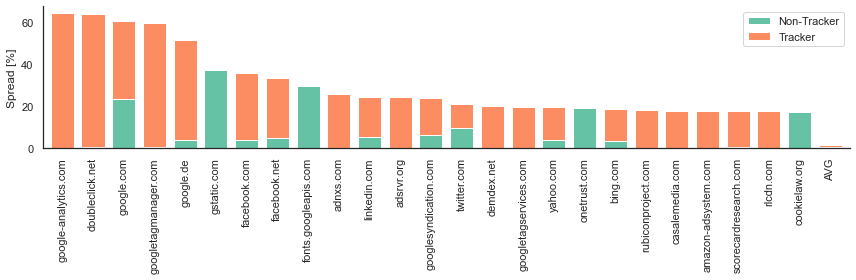

In [26]:
third_parties = pd.DataFrame()
third_parties['domain'] = resources[resources['is_tp']]['hostname']
third_parties['first_party'] = resources[resources['is_tp']]['first_party']
third_parties['is_tracker'] = resources[resources['is_tp']]['is_tracker']
third_party_count = {}
for party, gp in third_parties.groupby('domain'):
    third_party_count[party] = {'spread': len(gp['first_party'].unique()), 'is_tracker': gp['is_tracker'].sum() / len(gp)}

third_party_count = pd.DataFrame(third_party_count).T
third_party_count['spread'] = 100 * third_party_count['spread'] / len(resources['first_party'].unique())
third_party_count['tracker'] = third_party_count['spread'] * third_party_count['is_tracker']
third_party_count['nontracker'] = third_party_count['spread'] * (1 - third_party_count['is_tracker'])

top_third_party_count = third_party_count.sort_values(by='spread', ascending=False)[:25]
avg = third_party_count.mean()
top_third_party_count.loc['AVG'] = avg

ax = top_third_party_count.sort_values(by='spread', ascending=False).plot(y=['nontracker', 'tracker'], width=bar_width,
                                                                      kind="bar", stacked=True, color=color_cycle, figsize=(12,4))
#plt.title("Most widespread 3rd party")
ax.set_ylabel("Spread [%]")
plt.legend(["Non-Tracker", "Tracker"])
plt.tight_layout()
plt.savefig(ASSETS / f'top-tp-domain-by-first-party{CHART_FILE_EXTENSION}')
plt.show()

In [27]:
top_tps = top_third_party_count.index
"Top 25 tp hostnames occurs in first-party context with p={:.4f}".format(resources.groupby('website_call').agg({'hostname': lambda x: x.tolist()})['hostname'].apply(lambda x: any(xx in top_tps for xx in x)).sum() / 933)

'Top 25 tp hostnames occurs in first-party context with p=0.8489'

<AxesSubplot:xlabel='ip'>

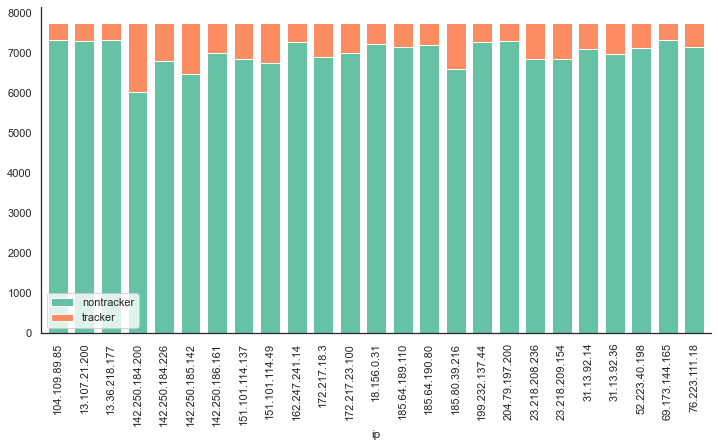

In [28]:
ip_tracker = pd.DataFrame()
gp = resources.groupby(['ip'])
ip_tracker['tracker'] = gp.apply(lambda x: x['is_tracker'].sum())
ip_tracker['nontracker'] = gp.apply(lambda x: len(gp) - x['is_tracker'].sum())
ip_tracker['hostname'] = gp.apply(lambda x: x['hostname'].unique())
ip_tracker['hostname_len'] = ip_tracker['hostname'].apply(len)
top_tracking_ip = ip_tracker.sort_values(by='tracker', ascending=False).iloc[:25]
top_tracking_ip.sort_index().plot(y=['nontracker', 'tracker'], kind="bar", width=bar_width, stacked=True, color=color_cycle, figsize=(12,6))



In [29]:
print(f"Mean domains per ip: {resources.groupby('ip')['hostname'].unique().apply(len).mean():.4f}")
print(f"Mean domains per tracker ip: {resources[resources['is_tracker']].groupby('ip')['hostname'].unique().apply(len).mean():.4f}")
print(f"Mean domains per non-tracker ip: {resources[~resources['is_tracker']].groupby('ip')['hostname'].unique().apply(len).mean():.4f}")
ip_tracker['is_popular_tp'] = ip_tracker['hostname'].apply(lambda x: any(domain in top_third_party_count.index for domain in x))
print(f"Mean domains per ip for popluar tp: {ip_tracker[ip_tracker['is_popular_tp']]['hostname_len'].mean():.4f}")
print(f"Top most domains per ip:")
display(ip_tracker.sort_values(by='hostname_len', ascending=False).head())

Mean domains per ip: 1.2634
Mean domains per tracker ip: 1.1584
Mean domains per non-tracker ip: 1.2442
Mean domains per ip for popluar tp: 1.9073
Top most domains per ip:


,tracker,nontracker,hostname,hostname_len,is_popular_tp
ip,,,,,
15.236.176.210,258,7490,"[omtrdc.net, news.com.au, boston.com, dowjoneson.com, gamespot.com, cnet.com, science.org, aarp.org, intel.com, webex.com, sky.com, nba.com, nbcnews.com, telegraph.co.uk, adobedc.net, imf.org, verisign.com, welt.de, acs.org, independent.co.uk, hilton.com, elsevier.com, demdex.net, globalnews.ca, microsoft.com, vmware.com, 2o7.net, cisco.com, politico.com, cbsnews.com, fifa.com, foodnetwork.com, sap.com, msnbc.com, adobe.com, redcross.org, elpais.com, last.fm, medscape.com, hbr.org, samsung.com, marriott.com]",42,True
151.101.114.133,183,7565,"[sagepub.com, pitt.edu, krxd.net, slate.com, healthline.com, filestackapi.com, colorado.edu, wistia.com, yale.edu, billboard.com, mparticle.com, ted.com, tedcdn.com, vogue.de, forbes.com, harvard.edu, theatlantic.com, euronews.com, w-x.co, arizona.edu, zend.com, nikkei.com, braze.com, stanford.edu, asu.edu, cbsinteractive.com, paypalobjects.com, paypal-mktg.com, dictionary.com, smh.com.au, ffx.io, epimg.net, elpais.com, prisasd.com, weather.com]",35,False
15.188.95.229,267,7481,"[omtrdc.net, cancer.gov, elsevier.com, apple.com, demdex.net, adobedc.net, science.org, foxbusiness.com, hp.com, bostonglobe.com, dtcidev.co, espn.com, foxnews.com, consumerreports.org, ihg.com, lww.com, zdnet.com, lenovo.com, nejm.org, cbc.ca, box.com, loc.gov, webmd.com, spiegel.de, nvidia.com, accenture.com, nbcuni.com, 2o7.net, microsoft.com, americanexpress.com, disney.de, dell.com, deloitte.com, cbsnews.com]",34,True
13.36.218.177,429,7319,"[omtrdc.net, 2o7.net, worldbank.org, cancer.gov, ups.com, aarp.org, cnn.com, standard.co.uk, webex.com, iheart.com, nbcnews.com, playstation.com, eurekalert.org, congress.gov, panasonic.com, dtcidev.co, nationalgeographic.com, spiegel.de, today.com, accenture.com, thestar.com, elsevier.com, kaspersky.de, timeout.com, ibm.com, mlb.com, fedex.com, wiley.com, cnet.com, nike.com, census.gov, microsoft.com]",32,False
151.101.114.132,74,7674,"[perl.org, ispot.tv, ziffstatic.com, outbrainimg.com, placed.com, outbrain.com, foxnews.com, esa.int, ketchcdn.com, hubvisor.io, techrepublic.com, wfxtriggers.com, amplitude.com, nikkei.com, perl.com, podbean.com, mutinycdn.com, theconversation.com, bcbits.com, tagcommander.com]",20,False


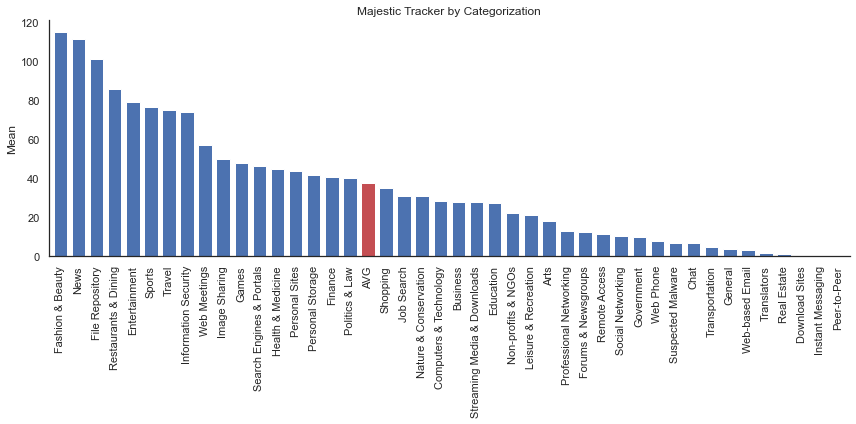

In [30]:
num_tracker = resources[resources['is_tracker']].groupby('website_call')['is_tracker'].count()
num_studies = resources[resources['is_tracker']].groupby('website_call')['study_name'].unique().apply(len)
num_tracker = pd.DataFrame([num_tracker, num_studies]).T
num_tracker['is_tracker'] = num_tracker['is_tracker'] / num_tracker['study_name']
num_tracker = num_tracker.join(categorization)
num_tracker = num_tracker.explode('categoryNames')
num_tracker = num_tracker.groupby('categoryNames')['is_tracker'].sum()
normalized_num_tracker = (num_tracker / num_categorization)
normalized_num_tracker = pd.concat([normalized_num_tracker, pd.Series({'AVG': normalized_num_tracker.mean()})]).sort_values(ascending=False)
ax = normalized_num_tracker.plot.bar(figsize=(12,6), width=bar_width)

highlight = 'AVG'
pos = normalized_num_tracker.index.get_loc(highlight)

ax.patches[pos].set_facecolor('r')

plt.title("Majestic Tracker by Categorization")
plt.ylabel("Mean")
plt.tight_layout()
plt.savefig(ASSETS / f'majestic-categorization-tracker{CHART_FILE_EXTENSION}')
plt.show()

In [31]:
res_cat = resources.merge(categorization, left_on='website_call', right_on='url')
res_cat = res_cat.explode('categoryNames')
print("Mean resources count: {:.2f}".format(resources[~resources['is_tracker']].groupby('website_call')['id'].count().mean()))
print("Mean resources count of last 20 categories: {:.2f}".format(res_cat[(res_cat['categoryNames'].isin(normalized_num_tracker.iloc[-20:].index)) & (~res_cat['is_tracker'])].groupby('website_call')['id'].count().mean()))
      

Mean resources count: 171.93
Mean resources count of last 20 categories: 130.42


## Feature Engineering

In [158]:
import warnings
    
def train_prevalence_ip(df):
    len_unique_webcalls = len(df['website_call'].unique())
    prevalence = df.groupby('ip').apply(lambda gp: len(gp['website_call'].unique()) / len_unique_webcalls)
    prevalence.name = 'ip_prevalence'
    return prevalence

def min_coll(collection):
    return np.min(collection) if len(collection) > 0 else None

def max_coll(collection):
    return np.max(collection) if len(collection) > 0 else None

def descriptive_statistics(df, col, level='R', precision=3):
    X = pd.DataFrame()
    col_name = lambda col, f: f"{level}:{f}({col})"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        X[col_name(col, "sum")] = df[col].apply(lambda x: np.sum(x)).round(precision)
        X[col_name(col, "mean")] = df[col].apply(lambda x: np.mean(x)).round(precision)
        X[col_name(col, "std")] = df[col].apply(lambda x: np.std(x)).round(precision)
        X[col_name(col, "min")] = df[col].apply(min_coll).round(precision)
        X[col_name(col, "max")] = df[col].apply(max_coll).round(precision)
        X[col_name(col, "span")] = X[col_name(col, "max")] - X[col_name(col, "min")]
    
    return X
  
def extract_communication_features(df, prevalence_ip=None):
    gp = df.groupby(['study_name', 'website_call', 'ip'])
    rs_tolist = lambda rs: [x for r in rs.tolist() for x in r]
    fns = {col: rs_tolist for col in ['packets', 'incoming', 'outgoing', 'sizes', 'incoming_sizes', 'outgoing_sizes', 'rel_time']}
    communication = gp.agg(fns | {'delta_req_time': lambda rs: rs.tolist()})
    
    communication['resource_sizes'] = gp.agg({'sizes': lambda rs: [sum(r) for r in rs.tolist()]})
    
        
    communication_r = communication.rename(columns={'outgoing': 'out packets', 'outgoing_sizes': 'out sizes', 
                                                    'incoming': 'in packets', 'incoming_sizes': 'in sizes',
                                                    'rel_time': 'rel time', 'delta_req_time': 'delta req time',
                                                    'resource_sizes': 'resource sizes'})
    
    X = pd.DataFrame()
    X['C:count(resources)'] = communication['resource_sizes'].apply(len)
    cols = ['packets', 'in packets', 'out packets']
    for col in cols:
        X[f"C:count({col})"] = communication_r[col].apply(len)
           
    cols = ['resource sizes', 'sizes', 'in sizes', 'out sizes', 'rel time', 'delta req time']
    for col in cols:
        X = pd.concat([X, descriptive_statistics(communication_r, col, level='C')], axis=1)
        
    if prevalence_ip is not None:
        communication = communication.join(prevalence_ip, on='ip')
        X['C:iprevalence(ip)'] = communication['ip_prevalence']
        
    X.drop(columns=['C:sum(resource sizes)', 'C:min(delta req time)', 'C:span(delta req time)', 'C:sum(rel time)'], inplace=True)
    cols = X.columns
    X = df.merge(X, left_on=['study_name', 'website_call', 'ip'], right_index=True)
    X = X.loc[df.index]
    
    return X[cols].fillna(-1)

def extract_resource_features(df):
    df_r = df.rename(columns={'outgoing': 'out packets', 'outgoing_sizes': 'out sizes', 
                                                    'incoming': 'in packets', 'incoming_sizes': 'in sizes',
                                                    'rel_time': 'rel time', 'delta_time': 'delta req time'})
    
    X = pd.DataFrame()
    cols = ['packets', 'in packets', 'out packets']
    for col in cols:
        X[f"R:count({col})"] = df_r[col].apply(len)
    
    cols = ['sizes', 'in sizes', 'out sizes', 'rel time']
    for col in cols:
        X = pd.concat([X, descriptive_statistics(df_r, col, level='R')], axis=1)
        
    X['R:delta req time'] = df['delta_req_time']
    X.drop(columns=['R:sum(rel time)'], inplace=True)
    
    return X.fillna(-1)

def extract_features(df, prevalence_ip=None, feature_names=False):
    com_features = extract_communication_features(df, prevalence_ip)
    res_features = extract_resource_features(df)
    
    X = pd.concat([com_features, res_features], axis=1)
    
    if feature_names:
        return X, {'communication': com_features.columns, 'resource': res_features.columns}
    else:
        return X

prevalence_ip = train_prevalence_ip(resources)
X_resource = extract_features(resources, prevalence_ip)
X_resource['is_tracker'] = resources['is_tracker']
X_resource.head()

,C:count(resources),C:count(packets),C:count(out packets),C:count(in packets),C:sum(resource sizes),C:sum(out resource sizes),C:sum(in resource sizes),C:mean(resource sizes),C:mean(out resource sizes),C:mean(in resource sizes),C:min(resource sizes),C:min(out resource sizes),C:min(in resource sizes),C:max(resource sizes),C:max(out resource sizes),C:max(in resource sizes),C:prevalence(ip),C:delta(req time),C:len(communication time),R:count(packets),R:count(out packets),R:sum(sizes),R:median(sizes),R:mean(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(out sizes),R:median(out sizes),R:mean(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:sum(rel time),R:median(rel time),R:mean(rel time),R:min(rel time),R:max(rel time),R:span(rel time),is_tracker
0,1,2,1,1,782,347,435,782.000000,347.00000,435.000000,782,347,435,782,347,435,0.001072,0.000000,0.190562,2,1,782,391.0,391.000000,347,435,88,347.0,347.0,347.0,347.0,347.0,0.0,0.999570,0.499785,0.499785,0.404504,0.595066,0.190562,False
1,47,389,47,342,464762,4744,460018,9888.553191,100.93617,9787.617021,953,56,864,98006,351,97834,0.002144,0.256696,0.307118,3,1,2116,351.0,705.333333,305,1460,1155,351.0,351.0,351.0,351.0,351.0,0.0,2.013607,0.676200,0.671202,0.661200,0.676207,0.015007,False
2,47,389,47,342,464762,4744,460018,9888.553191,100.93617,9787.617021,953,56,864,98006,351,97834,0.002144,0.016286,0.307118,16,1,21400,1460.0,1337.500000,56,1460,1404,56.0,56.0,56.0,56.0,56.0,0.0,11.089835,0.693987,0.693115,0.677486,0.694875,0.017389,False
3,47,389,47,342,464762,4744,460018,9888.553191,100.93617,9787.617021,953,56,864,98006,351,97834,0.002144,0.029657,0.307118,3,1,2863,1240.0,954.333333,163,1460,1297,163.0,163.0,163.0,163.0,163.0,0.0,2.151514,0.722181,0.717171,0.707143,0.722190,0.015047,False
4,47,389,47,342,464762,4744,460018,9888.553191,100.93617,9787.617021,953,56,864,98006,351,97834,0.002144,0.001121,0.307118,9,1,10350,1460.0,1150.000000,104,1460,1356,104.0,104.0,104.0,104.0,104.0,0.0,6.497190,0.723457,0.721910,0.708264,0.723898,0.015634,False


## Feature Analysis

### Visualizing

In [33]:
def remove_outliers(df, columns, n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

X_resource_wo = remove_outliers(X_resource, X_resource.columns[:-1], 4)

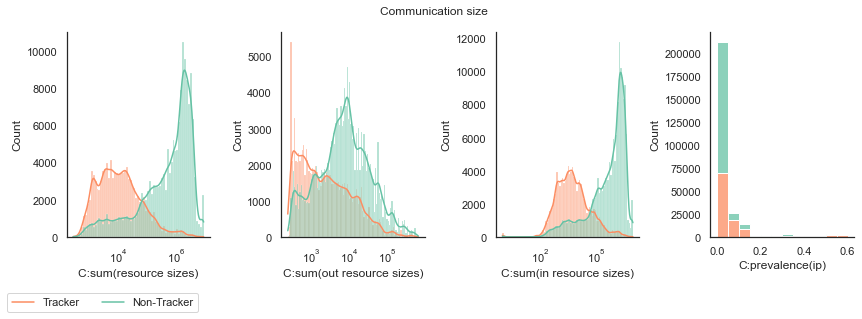

In [165]:
cols = ['C:sum(resource sizes)', 'C:sum(out resource sizes)', 'C:sum(in resource sizes)', 'C:prevalence(ip)']
fig, axs = plt.subplots(1, len(cols), figsize=(12,4))
for ax, col in zip(axs, cols):
    if col.startswith('C:sum'):
        sns.histplot(x=col, hue="is_tracker", data=X_resource.replace(to_replace=0, value=1), palette="Set2", kde=True, ax=ax, legend=False, log_scale=True)
    else:
        sns.histplot(x=col, hue="is_tracker", data=X_resource, multiple="stack", palette="Set2", ax=ax, legend=False, binwidth=0.05)
        #ax.set_yscale('log')
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Communication size")
fig.tight_layout()
fig.savefig(ASSETS / f'feature-communication-length{CHART_FILE_EXTENSION}')

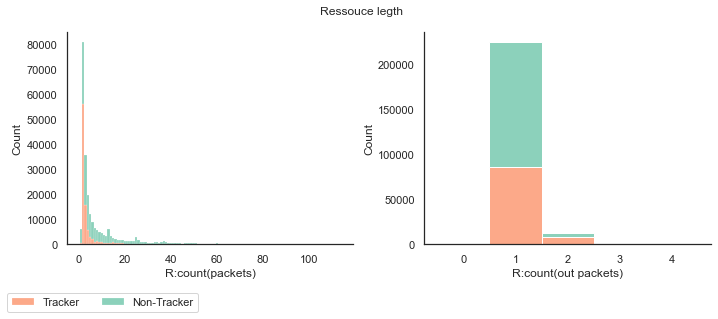

In [36]:
cols = ['R:count(packets)', 'R:count(out packets)']
fig, axs = plt.subplots(1, len(cols), figsize=(10,4))
for ax, col in zip(axs, cols):
    sns.histplot(x=col, hue="is_tracker", data=X_resource_wo, palette="Set2", multiple="stack", ax=ax, legend=False, discrete=True)
    
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Ressouce legth")
fig.tight_layout()
fig.savefig(ASSETS / f'feature-packet-count{CHART_FILE_EXTENSION}')

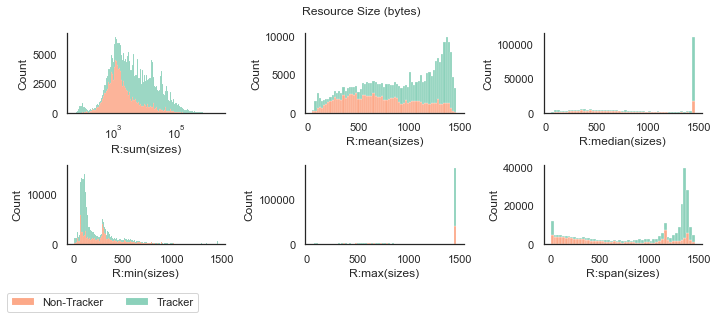

In [37]:
cols = [['R:sum(sizes)', 'R:mean(sizes)', 'R:std(sizes)'], ['R:min(sizes)', 'R:max(sizes)', 'R:span(sizes)']]
fig, axs = plt.subplots(len(cols), len(cols[0]), figsize=(10,4))
for i, row in enumerate(cols):
    for ax, col in zip(axs[i], row):
        if col == 'R:sum(sizes)':
            sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False, log_scale=True)
        else:
            sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False)

fig.legend(['Non-Tracker', 'Tracker'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Resource Size (bytes)")
fig.tight_layout()
fig.savefig(ASSETS / f'feature-size{CHART_FILE_EXTENSION}')

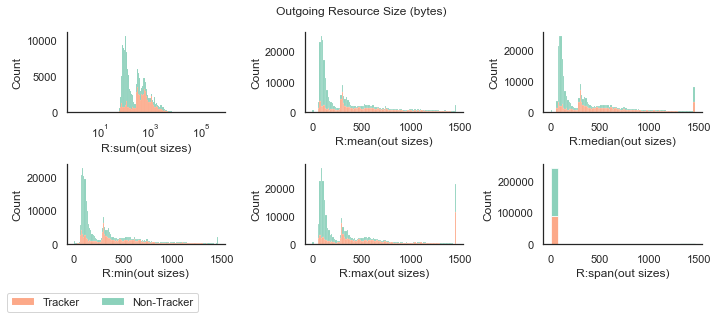

In [38]:
cols = [['R:sum(out sizes)', 'R:mean(out sizes)', 'R:std(out sizes)'], ['R:min(out sizes)', 'R:max(out sizes)', 'R:span(out sizes)']]
fig, axs = plt.subplots(len(cols), len(cols[0]), figsize=(10,4))
for i, row in enumerate(cols):
    for ax, col in zip(axs[i], row):
        if col == 'R:sum(out sizes)':
            sns.histplot(x=col, hue="is_tracker", data=X_resource.replace(to_replace=0, value=1), palette="Set2", multiple="stack", ax=ax, legend=False, log_scale=True)
        else:
            sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False)

fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Outgoing Resource Size (bytes)")
plt.tight_layout()
fig.tight_layout()
fig.savefig(ASSETS / f'feature-outgoing-size{CHART_FILE_EXTENSION}')

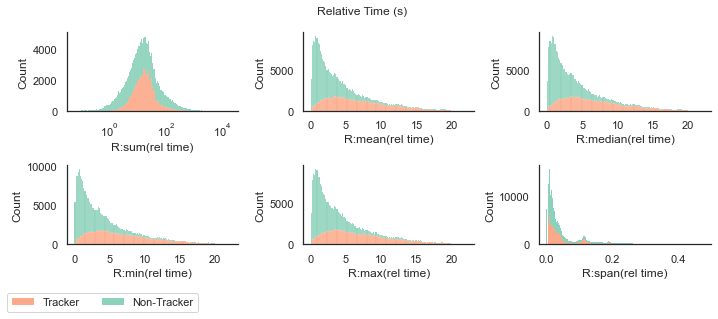

In [39]:
cols = [['R:sum(rel time)', 'R:mean(rel time)', 'R:std(rel time)'], ['R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)']]
fig, axs = plt.subplots(len(cols), len(cols[0]), figsize=(10,4))
for i, row in enumerate(cols):
    for ax, col in zip(axs[i], row):
        if col == 'R:sum(rel time)':
            sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False, log_scale=True)
        else:
            sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False)

axs[1][2].set_xlim(-0.02, 0.5)
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower left', bbox_to_anchor=(0,-.1), bbox_transform=fig.transFigure)
fig.suptitle("Relative Time (s)")
fig.tight_layout()
fig.savefig(ASSETS / f'feature-rel-time{CHART_FILE_EXTENSION}')

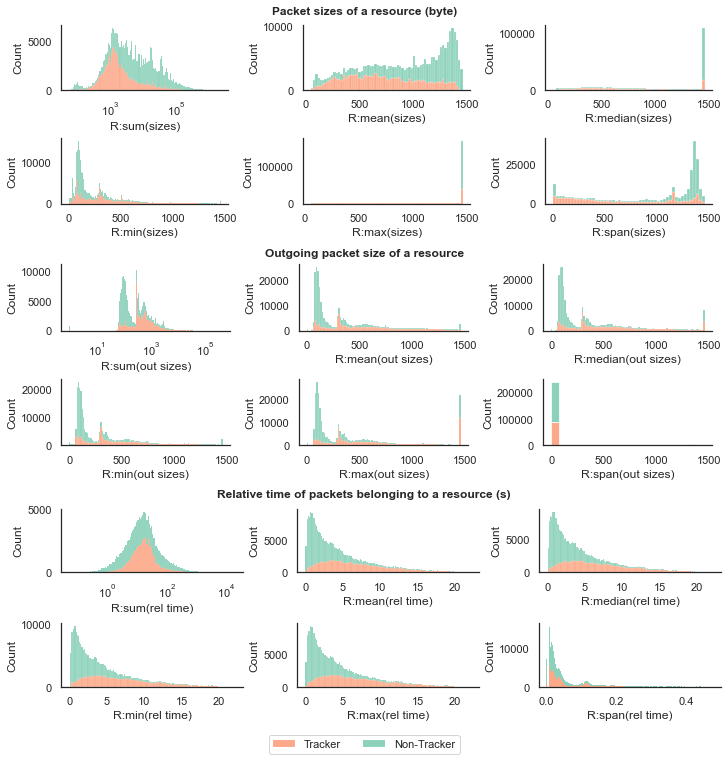

In [40]:
cols3d = [[['R:sum(sizes)', 'R:mean(sizes)', 'R:std(sizes)'],
          ['R:min(sizes)', 'R:max(sizes)', 'R:span(sizes)']],
        
        [['R:sum(out sizes)', 'R:mean(out sizes)', 'R:std(out sizes)'], 
         ['R:min(out sizes)', 'R:max(out sizes)', 'R:span(out sizes)']],
        
        [['R:sum(rel time)', 'R:mean(rel time)', 'R:std(rel time)'], 
         ['R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)']]]


fig = plt.figure(constrained_layout=True, figsize=(10,10))
subfigs = fig.subfigures(nrows=len(cols3d), ncols=1)
titles = ["Packet sizes of a resource (byte)", "Outgoing packet size of a resource", "Relative time of packets belonging to a resource (s)"]

for title, subfig, cols2d in zip(titles, subfigs, cols3d):
    subfig.suptitle(title, fontweight='bold')
    axs = subfig.subplots(len(cols2d), len(cols2d[0]))

    for i, cols1d in enumerate(cols2d):
        for ax, col in zip(axs[i], cols1d):
            if "sum" in col:
                sns.histplot(x=col, hue="is_tracker", data=X_resource.replace(to_replace=0, value=1), palette="Set2", multiple="stack", ax=ax, legend=False, log_scale=True)
            else:
                sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", multiple="stack", ax=ax, legend=False)
                
    if title == titles[-1]:
        axs[1][2].set_xlim(-0.02, 0.5)
        
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower center', bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.savefig(ASSETS / f'feature-distribution.{CHART_FILE_EXTENSION}', bbox_inches='tight')

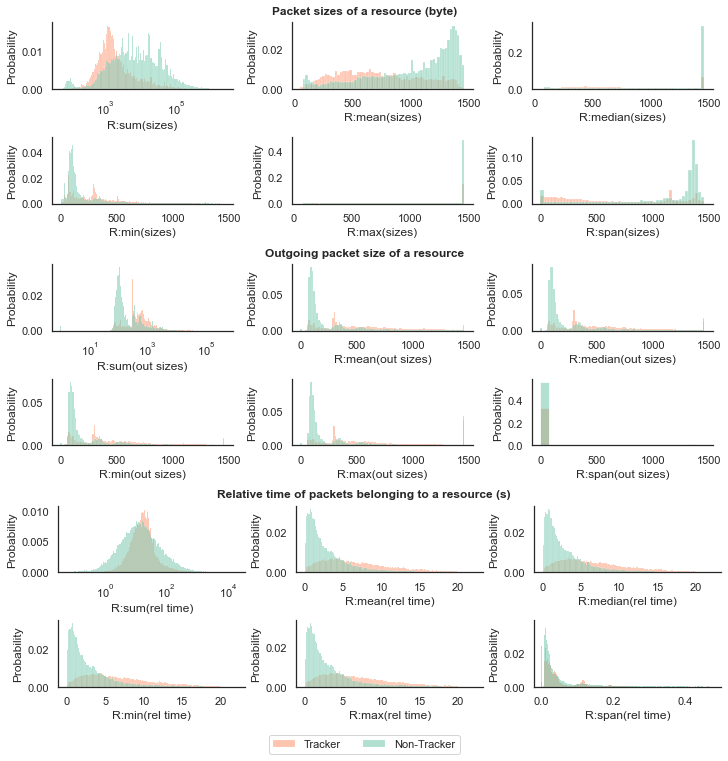

In [41]:
cols3d = [[['R:sum(sizes)', 'R:mean(sizes)', 'R:std(sizes)'],
          ['R:min(sizes)', 'R:max(sizes)', 'R:span(sizes)']],
        
        [['R:sum(out sizes)', 'R:mean(out sizes)', 'R:std(out sizes)'], 
         ['R:min(out sizes)', 'R:max(out sizes)', 'R:span(out sizes)']],
        
        [['R:sum(rel time)', 'R:mean(rel time)', 'R:std(rel time)'], 
         ['R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)']]]

fig = plt.figure(constrained_layout=True, figsize=(10,10))
subfigs = fig.subfigures(nrows=len(cols3d), ncols=1)
titles = ["Packet sizes of a resource (byte)", "Outgoing packet size of a resource", "Relative time of packets belonging to a resource (s)"]

for title, subfig, cols2d in zip(titles, subfigs, cols3d):
    subfig.suptitle(title, fontweight='bold')
    axs = subfig.subplots(len(cols2d), len(cols2d[0]))

    for i, cols1d in enumerate(cols2d):
        for ax, col in zip(axs[i], cols1d):
            if "sum" in col:
                sns.histplot(x=col, hue="is_tracker", data=X_resource.replace(to_replace=0, value=1), palette="Set2", stat="probability", ax=ax, legend=False, log_scale=True)
            else:
                sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", stat="probability", ax=ax, legend=False)
                
    if title == titles[-1]:
        axs[1][2].set_xlim(-0.02, 0.5)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower center', bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.savefig(ASSETS / f'feature-distribution-probability.{CHART_FILE_EXTENSION}', bbox_inches='tight')

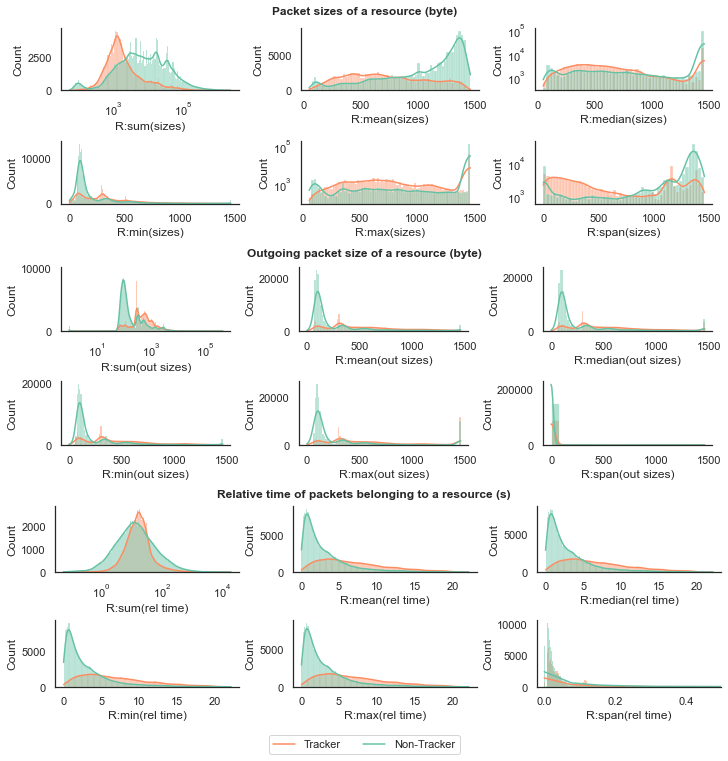

In [60]:
cols3d = [[['R:sum(sizes)', 'R:mean(sizes)', 'R:std(sizes)'],
          ['R:min(sizes)', 'R:max(sizes)', 'R:span(sizes)']],
        
        [['R:sum(out sizes)', 'R:mean(out sizes)', 'R:std(out sizes)'], 
         ['R:min(out sizes)', 'R:max(out sizes)', 'R:span(out sizes)']],
        
        [['R:sum(rel time)', 'R:mean(rel time)', 'R:std(rel time)'], 
         ['R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)']]]


fig = plt.figure(constrained_layout=True, figsize=(10,10))
subfigs = fig.subfigures(nrows=len(cols3d), ncols=1)
titles = ["Packet sizes of a resource (byte)", "Outgoing packet size of a resource (byte)", "Relative time of packets belonging to a resource (s)"]

for title, subfig, cols2d in zip(titles, subfigs, cols3d):
    subfig.suptitle(title, fontweight='bold')
    axs = subfig.subplots(len(cols2d), len(cols2d[0]))

    for i, cols1d in enumerate(cols2d):
        for ax, col in zip(axs[i], cols1d):
            if "sum" in col:
                sns.histplot(x=col, hue="is_tracker", data=X_resource.replace(to_replace=0, value=1), palette="Set2", kde=True, ax=ax, legend=False, log_scale=True)
            else:
                sns.histplot(x=col, hue="is_tracker", data=X_resource, palette="Set2", kde=True, ax=ax, legend=False)
             
            if any(c == col for c in ["R:median(sizes)", "R:max(sizes)", "R:span(sizes)"]):
                ax.set_yscale('log')
                
    if title == titles[-1]:
        axs[1][2].set_xlim(-0.02, 0.5)
                                
fig.legend(['Tracker', 'Non-Tracker'], ncol=2, loc='lower center', bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
#fig.savefig(ASSETS / f'feature-distribution-kde.{CHART_FILE_EXTENSION}', bbox_inches='tight')
plt.show()

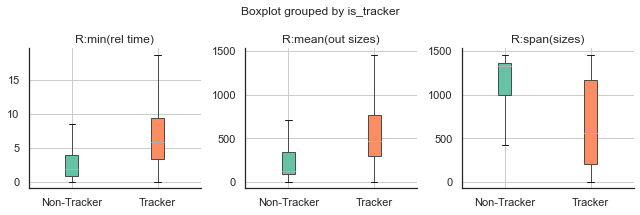

In [44]:
cols = ['R:min(rel time)', 'R:mean(out sizes)', 'R:span(sizes)']
fig, axs = plt.subplots(1, len(cols), figsize=(3*len(cols),3))

for ax, col in zip(axs, cols):
    bp_dict = X_resource.boxplot(column=col, by='is_tracker', ax=ax, return_type='both', patch_artist=True, showfliers=False)

    for row_key, (ax,row) in bp_dict.iteritems():
        ax.set_xlabel('')
        ax.set_xticklabels(['Non-Tracker', 'Tracker'])
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(color_cycle[i])
        
fig.tight_layout()
fig.savefig(ASSETS / f'boxplot-best-features{CHART_FILE_EXTENSION}')

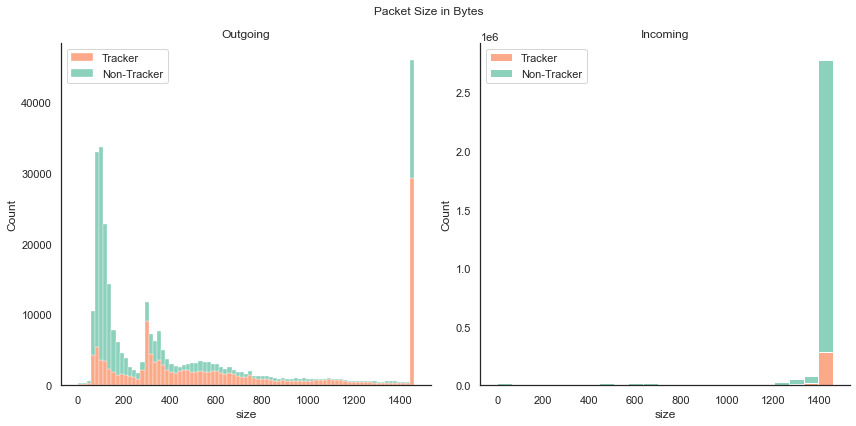

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
for is_req, gp in  packets.groupby('out'):
    l = "Outgoing" if is_req else "Incoming"
    ax = axs[0] if is_req else axs[1]
    sns.histplot(x="size", hue="is_tracker", data=gp, palette="Set2", multiple="stack", ax=ax, label=l)
    ax.set_title(l)
    ax.legend(['Tracker', 'Non-Tracker'])

fig.suptitle("Packet Size in Bytes")
fig.tight_layout()
plt.savefig(ASSETS / f'packet-size-by-tracker{CHART_FILE_EXTENSION}')
plt.show()

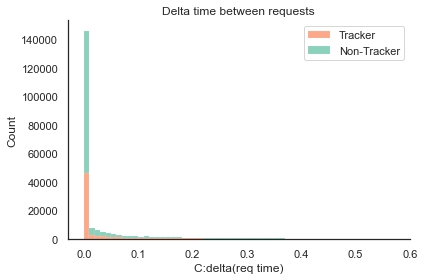

In [46]:
sns.histplot(x='C:delta(req time)', hue='is_tracker', data=X_resource_wo, palette="Set2", multiple="stack", binwidth=.01)
plt.xlim(-0.03, 0.6)
plt.legend(['Tracker', 'Non-Tracker'])
plt.title("Delta time between requests")
plt.tight_layout()
plt.savefig(ASSETS / f'delta-time-between-requests-by-tracker{CHART_FILE_EXTENSION}')
plt.show()

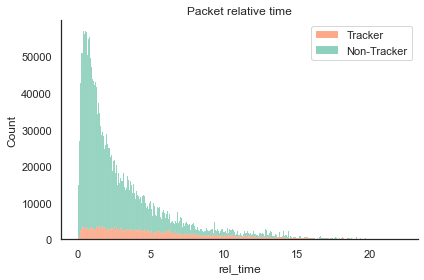

In [47]:
sns.histplot(x='rel_time', hue='is_tracker', data=packets, palette="Set2", multiple="stack")
plt.legend(['Tracker', 'Non-Tracker'])
plt.title("Packet relative time")
plt.tight_layout()
plt.savefig(ASSETS / f'packet-rel-time-by-tracker{CHART_FILE_EXTENSION}')
plt.show()

In [48]:
packets.groupby('study_name')['rel_time'].max()

study_name
accepting policy    20.783604
after accept        22.139475
before accept       20.277383
Name: rel_time, dtype: float64

### Hypothesis testing

#### Resource level

In [61]:
def ttest(a, b, niveau=0.05, alt='two-sided'):
    if len(a) <= 30 or len(b) <= 30:
        print("Sample size is smaller than 30, test for normal distribution with shapiro test")
        a_norm = stats.shapiro(a)
        b_norm = stats.shapiro(b)
        if a_norm.pvalue < niveau:
            print(f"Samle {a.name} is not normal distributed")
            return None
        if b_norm.pvalue < niveau:
            print(f"Samle {b.name} is not normal distributed")
            return None
        
    var_hom = stats.levene(a, b).pvalue >= niveau
    ttest = stats.ttest_ind(a, b, equal_var=var_hom, alternative=alt)
    
    return ttest, var_hom
            

test_results = {}
for col in X_resource.columns[:-1]:
    g1 = X_resource[X_resource['is_tracker']][col]
    g2 = X_resource[~X_resource['is_tracker']][col]
    
    res = {'var_diff': g1.var() / g2.var()}
    for alt in ['two-sided', 'less', 'greater']:
        t, var_hom = ttest(g1, g2, alt=alt)
        res['var_hom'] = var_hom
        if t is not None:
            res[alt] = t.pvalue
        else:
            res[alt] = None
    
    test_results[col] = res

print("G1[is_tracker] vs. G2[not is_tracker]: less means g1 < g2, greater means g1 > g2")
pd.DataFrame(test_results).T

G1[is_tracker] vs. G2[not is_tracker]: less means g1 < g2, greater means g1 > g2


,var_diff,var_hom,two-sided,less,greater
R:count(packets),0.077962,False,0.0,0.0,1.0
R:count(out packets),12.761626,False,0.0,1.0,0.0
C:delta(req time),5.017846,False,0.0,1.0,0.0
R:sum(sizes),0.076324,False,0.0,0.0,1.0
R:median(sizes),0.881511,False,0.0,0.0,1.0
R:mean(sizes),0.889034,True,0.0,0.0,1.0
R:min(sizes),1.198621,False,0.0,1.0,0.0
R:max(sizes),1.495194,False,0.0,0.0,1.0
R:span(sizes),1.304247,False,0.0,0.0,1.0
R:sum(out sizes),11.541015,False,0.0,1.0,0.0


### Korrelation

#### Cramer's V

In [50]:
from scipy.stats.contingency import association

association(pd.crosstab(index=resources['ip'],columns=resources['is_tracker']), correction=True)

0.9207457154222795

#### Punktbiseriale Korrelation

<AxesSubplot:>

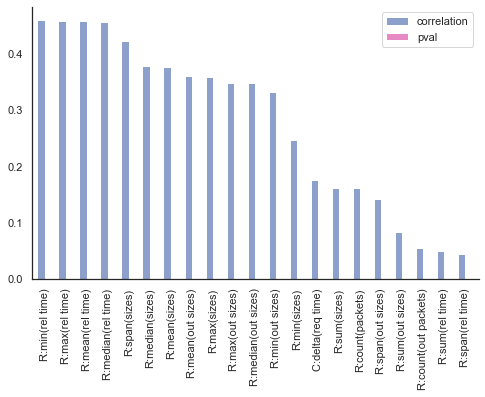

In [51]:
correlation = {col: stats.pointbiserialr(X_resource[col], resources['is_tracker']) for col in X_resource.columns[:-1]}
correlation = pd.DataFrame(correlation).T
correlation.columns = ['correlation', 'pval']
correlation['correlation'] = correlation['correlation'].abs()
correlation = correlation.sort_values(by='correlation', ascending=False)
correlation.plot.bar(color=color_cycle[2:], width=bar_width, figsize=(8,5))